### CNN

### Import libraries

In [2]:
!pip install optuna

import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
import optuna
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Preprocessing module

In [3]:
# Load data
train_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv'
test_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv'

train_df = pd.read_csv(train_url, header=None)
test_df = pd.read_csv(test_url, header=None)
train_df.columns = ['Class Index', 'Title', 'Description']
test_df.columns = ['Class Index', 'Title', 'Description']

In [4]:
# Define stop words and lemmatizer for text cleaning
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower() # convert text to lowercase
    text = re.sub(r'\b(u\.s\.|us)\b', 'usa', text, flags=re.IGNORECASE)  # replace "U.S." or "US" with "usa"
    text = re.sub(r'<[^>]+>', '', text)  # remove HTML tags
    text = re.sub(r'&\w+;', '', text)  # remove HTML entities
    text = re.sub(r'[^a-z\s]', '', text)  # remove numbers and punctuation (keep only letters and spaces)
    words = text.split()
    words = [word for word in words if word not in stop_words] # remove stop-words, tokenization
    words = [lemmatizer.lemmatize(word) for word in words] # lemmatization
    return ' '.join(words) # combining words into a string

# Apply preprocessing
train_df['clean_text'] = (train_df['Title'] + ' ' + train_df['Description']).apply(preprocess_text)
test_df['clean_text'] = (test_df['Title'] + ' ' + test_df['Description']).apply(preprocess_text)

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['clean_text'])
max_length_titles = max([len(x.split()) for x in train_df['Title']])
max_length_descriptions = max([len(x.split()) for x in train_df['Description']])

X_train_title_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['Title']), maxlen=max_length_titles)
X_test_title_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['Title']), maxlen=max_length_titles)
X_train_description_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['Description']), maxlen=max_length_descriptions)
X_test_description_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['Description']), maxlen=max_length_descriptions)

y_train = train_df['Class Index'].values - 1
y_test = test_df['Class Index'].values - 1

# Download and load GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((5000, 100))
for word, i in tokenizer.word_index.items():
    if i < 5000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(input_dim=5000, output_dim=100, weights=[embedding_matrix], trainable=False)

--2024-10-29 16:13:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-29 16:13:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-29 16:13:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

### Basic training module

In [5]:
# Define CNN model architecture
title_input = Input(shape=(max_length_titles,), name='title_input')
title_embedding = embedding_layer(title_input)
title_conv1d = Conv1D(filters=128, kernel_size=3, activation='relu')(title_embedding)
title_maxpool = MaxPooling1D(pool_size=2)(title_conv1d)
title_flatten = Flatten()(title_maxpool)

description_input = Input(shape=(max_length_descriptions,), name='description_input')
description_embedding = embedding_layer(description_input)
description_conv1d = Conv1D(filters=128, kernel_size=3, activation='relu')(description_embedding)
description_maxpool = MaxPooling1D(pool_size=2)(description_conv1d)
description_flatten = Flatten()(description_maxpool)

merged = Concatenate()([title_flatten, description_flatten])
dense_1 = Dense(128, activation='relu')(merged)
dense_2 = Dense(64, activation='relu')(dense_1)
output = Dense(4, activation='softmax')(dense_2)

model = Model(inputs=[title_input, description_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=3e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the baseline model
model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1,
          epochs=5, batch_size=32, callbacks=[early_stopping], verbose=1)

Epoch 1/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7813 - loss: 0.6437 - val_accuracy: 0.8655 - val_loss: 0.3774
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8717 - loss: 0.3665 - val_accuracy: 0.8715 - val_loss: 0.3576
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8803 - loss: 0.3398 - val_accuracy: 0.8731 - val_loss: 0.3503
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8878 - loss: 0.3173 - val_accuracy: 0.8750 - val_loss: 0.3458
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8941 - loss: 0.3018 - val_accuracy: 0.8752 - val_loss: 0.3450


### Testing Module 1 (Base Model)

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Baseline Test Accuracy: 0.8772
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1900
           1       0.95      0.94      0.94      1900
           2       0.82      0.85      0.84      1900
           3       0.83      0.87      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



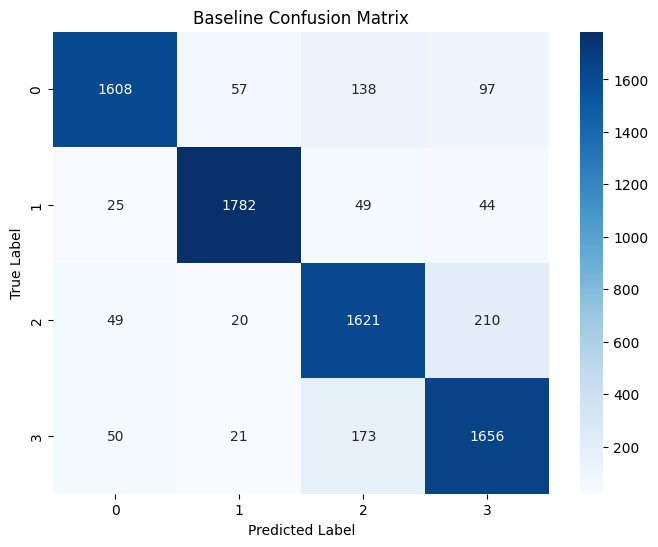

In [6]:
# Evaluate baseline model
y_pred = model.predict([X_test_title_pad, X_test_description_pad])
y_pred_classes = y_pred.argmax(axis=1)

baseline_accuracy = (y_pred_classes == y_test).mean()
print(f'Baseline Test Accuracy: {baseline_accuracy:.4f}')
print("Baseline Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Baseline Confusion Matrix')
plt.show()

### Hyperparameter selection module

In [8]:
def model_builder(trial):
    # Define hyperparameters for optimization
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    filters = trial.suggest_int('filters', 64, 256)
    kernel_size = trial.suggest_int('kernel_size', 3, 5)
    num_units = trial.suggest_int('num_units', 64, 512)

    # Define CNN model structure with Optuna parameters
    title_input = Input(shape=(max_length_titles,), name='title_input')
    title_embedding = embedding_layer(title_input)
    title_conv1d = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(title_embedding)
    title_maxpool = MaxPooling1D(pool_size=2)(title_conv1d)
    title_flatten = Flatten()(title_maxpool)

    description_input = Input(shape=(max_length_descriptions,), name='description_input')
    description_embedding = embedding_layer(description_input)
    description_conv1d = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(description_embedding)
    description_maxpool = MaxPooling1D(pool_size=2)(description_conv1d)
    description_flatten = Flatten()(description_maxpool)

    merged = Concatenate()([title_flatten, description_flatten])
    dense_1 = Dense(num_units, activation='relu')(merged)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    output = Dense(4, activation='softmax')(dropout_1)

    model = Model(inputs=[title_input, description_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Objective function for Optuna
def objective(trial):
    model = model_builder(trial)
    model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1, epochs=3, batch_size=32, verbose=1)
    _, accuracy = model.evaluate([X_test_title_pad, X_test_description_pad], y_test, verbose=1)
    return accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
print("Best Trial:", study.best_trial)

[I 2024-10-29 16:19:06,200] A new study created in memory with name: no-name-d311530b-7fc0-444c-980a-19de36fdc480


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8412 - loss: 0.4491 - val_accuracy: 0.8898 - val_loss: 0.3116
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8964 - loss: 0.2951 - val_accuracy: 0.8928 - val_loss: 0.2982
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9115 - loss: 0.2463 - val_accuracy: 0.8904 - val_loss: 0.3175
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8914 - loss: 0.3275


[I 2024-10-29 16:20:03,656] Trial 0 finished with value: 0.8913158178329468 and parameters: {'dropout_rate': 0.28247619800601437, 'learning_rate': 0.00020451284943189465, 'filters': 66, 'kernel_size': 4, 'num_units': 492}. Best is trial 0 with value: 0.8913158178329468.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8569 - loss: 0.4195 - val_accuracy: 0.8884 - val_loss: 0.3085
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9020 - loss: 0.2822 - val_accuracy: 0.8954 - val_loss: 0.2953
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9156 - loss: 0.2359 - val_accuracy: 0.8911 - val_loss: 0.3058
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8950 - loss: 0.3102


[I 2024-10-29 16:20:46,579] Trial 1 finished with value: 0.8927631378173828 and parameters: {'dropout_rate': 0.34404475247391436, 'learning_rate': 0.0015689656405192753, 'filters': 174, 'kernel_size': 4, 'num_units': 64}. Best is trial 1 with value: 0.8927631378173828.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8422 - loss: 0.4406 - val_accuracy: 0.8899 - val_loss: 0.3012
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9020 - loss: 0.2806 - val_accuracy: 0.8875 - val_loss: 0.3126
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9187 - loss: 0.2309 - val_accuracy: 0.8908 - val_loss: 0.3023
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8959 - loss: 0.3068


[I 2024-10-29 16:21:32,950] Trial 2 finished with value: 0.894473671913147 and parameters: {'dropout_rate': 0.4230192117719541, 'learning_rate': 0.0004209952577676546, 'filters': 82, 'kernel_size': 4, 'num_units': 174}. Best is trial 2 with value: 0.894473671913147.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.7514 - loss: 0.7076 - val_accuracy: 0.8625 - val_loss: 0.3918
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8653 - loss: 0.3937 - val_accuracy: 0.8719 - val_loss: 0.3639
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8748 - loss: 0.3620 - val_accuracy: 0.8777 - val_loss: 0.3510
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8680 - loss: 0.3824


[I 2024-10-29 16:22:35,915] Trial 3 finished with value: 0.8717105388641357 and parameters: {'dropout_rate': 0.3792241650675745, 'learning_rate': 1.4488207137873634e-05, 'filters': 244, 'kernel_size': 3, 'num_units': 204}. Best is trial 2 with value: 0.894473671913147.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8098 - loss: 0.5367 - val_accuracy: 0.8811 - val_loss: 0.3332
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8825 - loss: 0.3334 - val_accuracy: 0.8858 - val_loss: 0.3256
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8963 - loss: 0.2989 - val_accuracy: 0.8882 - val_loss: 0.3077
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8814 - loss: 0.3382


[I 2024-10-29 16:23:38,695] Trial 4 finished with value: 0.8863157629966736 and parameters: {'dropout_rate': 0.2942582688139072, 'learning_rate': 5.0039863920682774e-05, 'filters': 141, 'kernel_size': 4, 'num_units': 303}. Best is trial 2 with value: 0.894473671913147.


Best Trial: FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.894473671913147], datetime_start=datetime.datetime(2024, 10, 29, 16, 20, 46, 580205), datetime_complete=datetime.datetime(2024, 10, 29, 16, 21, 32, 949658), params={'dropout_rate': 0.4230192117719541, 'learning_rate': 0.0004209952577676546, 'filters': 82, 'kernel_size': 4, 'num_units': 174}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'filters': IntDistribution(high=256, log=False, low=64, step=1), 'kernel_size': IntDistribution(high=5, log=False, low=3, step=1), 'num_units': IntDistribution(high=512, log=False, low=64, step=1)}, trial_id=2, value=None)


### Testing module 2 (Optimized Model)

Epoch 1/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8448 - loss: 0.4400 - val_accuracy: 0.8882 - val_loss: 0.3072
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9015 - loss: 0.2846 - val_accuracy: 0.8938 - val_loss: 0.2886
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9189 - loss: 0.2316 - val_accuracy: 0.8917 - val_loss: 0.3000
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9321 - loss: 0.1900 - val_accuracy: 0.8917 - val_loss: 0.3180
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9435 - loss: 0.1580 - val_accuracy: 0.8882 - val_loss: 0.3537
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Final Test Accuracy: 0.8929
Final Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1900
           1       0.93      0.98      0.95      1900
           2       0.86      0.85      0.85      1900
           3       0.84      0.90  

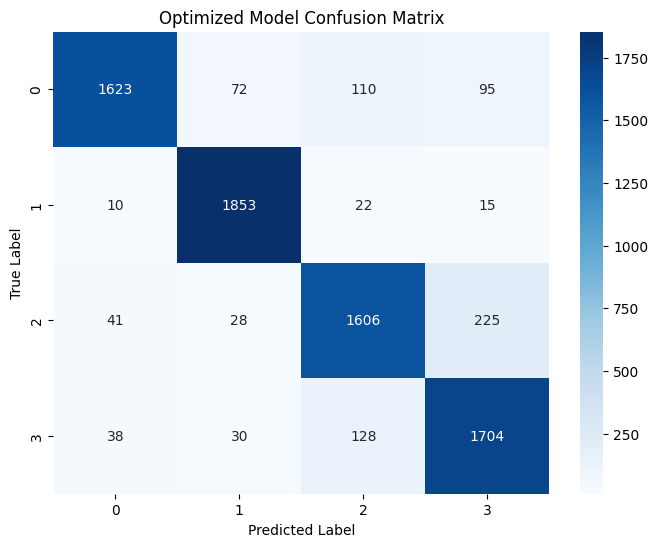

In [9]:
# Load the best model from Optuna optimization
best_trial = study.best_trial
model = model_builder(best_trial)
model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1, epochs=5, batch_size=32, verbose=1)

# Evaluate optimized model
y_pred = model.predict([X_test_title_pad, X_test_description_pad])
y_pred_classes = y_pred.argmax(axis=1)

final_accuracy = (y_pred_classes == y_test).mean()
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print("Final Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix for optimized model
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Optimized Model Confusion Matrix')
plt.show()